In [1]:
import numpy as np
import matplotlib.pyplot as plt

from SimPEG import Mesh
from SimPEG import Utils
from SimPEG import Maps
from SimPEG import Regularization
from SimPEG import DataMisfit
from SimPEG import Optimization
from SimPEG import InvProblem
from SimPEG import Directives
from SimPEG import Inversion
from SimPEG import PF




In [2]:
# Create a mesh
dx = 5.

hxind = [(dx, 5, -1.3), (dx, 15), (dx, 5, 1.3)]
hyind = [(dx, 5, -1.3), (dx, 15), (dx, 5, 1.3)]
hzind = [(dx, 5, -1.3), (dx, 7), (3.5, 1), (2, 5)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

# # Lets create a simple Gaussian topo and set the active cells
# [xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
# zz = -np.exp((xx**2 + yy**2) / 75**2) + mesh.vectorNz[-1]

# # We would usually load a topofile
# topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Go from topo to actv cells
actv = np.ones(mesh.nC, dtype='bool')#Utils.surface2ind_topo(mesh, topo, 'N')
# actv = np.asarray([inds for inds, elem in enumerate(actv, 1) if elem],
#                   dtype=int) - 1

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = len(actv)



In [6]:
# Create and array of observation points
xr = np.linspace(-30., 30., 20)
yr = np.linspace(-30., 30., 20)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.ones_like(X) * mesh.vectorNz[-1] + 1

# Create a MAGsurvey
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseGrav.RxObs(rxLoc)
srcField = PF.BaseGrav.SrcField([rxLoc])
survey = PF.BaseGrav.LinearSurvey(srcField)



In [7]:
# We can now create a susceptibility model and generate data
# Here a simple block in half-space
model = np.zeros((mesh.nCx, mesh.nCy, mesh.nCz))
model[(midx-5):(midx-1), (midy-2):(midy+2), -10:-6] = 0.5
model[(midx+1):(midx+5), (midy-2):(midy+2), -10:-6] = -0.5
model = Utils.mkvc(model)
model = model[actv]

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Create reduced identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create the forward model operator
prob = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv)

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
d = prob.fields(model)

# Add noise and uncertainties
# We add some random Gaussian noise (1nT)
data = d + np.random.randn(len(d))*1e-3
wd = np.ones(len(data))*1e-3  # Assign flat uncertainties

survey.dobs = data
survey.std = wd
survey.mtrue = model

# Create sensitivity weights from our linear forward operator
rxLoc = survey.srcField.rxList[0].locs
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr/np.max(wr))



Begin calculation of forward operator: z
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



In [8]:
# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr
reg.norms = [0, 1, 1, 1]

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = Utils.sdiag(1/wd)

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=10,
                                 tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
# model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-2, minGNiter=3)
update_Jacobi = Directives.Update_lin_PreCond()
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,
                                                      betaest,
                                                      update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.69e+07  5.66e+04  0.00e+00  5.66e+04    1.06e+02      0              
   1  2.84e+07  5.60e+04  4.95e-06  5.62e+04    1.06e+02      0              
   2  1.42e+07  5.55e+04  1.95e-05  5.58e+04    1.06e+02      0   Skip BFGS  
   3  7.11e+06  5.44e+04  7.59e-05  5.50e+04    1.06e+02      0   Skip BFGS  
   4  3.55e+06  5.24e+04  2.88e-04  5.34e+04    1.06e+02      0   Skip BFGS  
   5  1.78e+06  4.88e+04  1.05e-03  5.06e+04    1.06e+02      0   Skip 

In [ ]:
IRLS.l2model

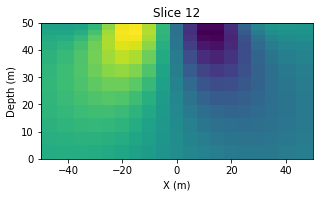

In [25]:
midy = int(mesh.vnC[1]/2)
fig = plt.figure(figsize=(5, 2.5))
ax2 = plt.subplot()
mesh.plotSlice(IRLS.l2model, normal='Y', ind=midy, ax=ax2)
loc = ax2.get_position()
ax2.set_aspect('equal')
ax2.set_position([loc.x0+0.025, loc.y0+0.025, loc.width, loc.height])
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Depth (m)')
ax2.axis([-50, 50, 0, 50])
plt.show()

In [ ]:
# Create subproblem
